# Disaster Tweets Analysis

## 1. Import Libraries, funtions and dataset

In [1]:
!pip3 install category_encoders
!pip3 install --quiet tensorflow
!pip3 install --quiet tensorflow-text
!pip3 install -q -U keras-tuner

     |████████████████████████████████| 80 kB 3.0 MB/s 
     |████████████████████████████████| 4.4 MB 2.7 MB/s 
     |████████████████████████████████| 97 kB 3.5 MB/s 


In [2]:
!wget https://github.com/gurokeretcha/Tweets-classification-Disaster-No_Disaster-using-NLP/raw/main/nlp-getting-started.zip
!wget https://raw.githubusercontent.com/gurokeretcha/gurokeretcha/main/helper_funtions_ML.py

--2021-10-10 09:15:54--  https://github.com/gurokeretcha/Tweets-classification-Disaster-No_Disaster-using-NLP/raw/main/nlp-getting-started.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gurokeretcha/Tweets-classification-Disaster-No_Disaster-using-NLP/main/nlp-getting-started.zip [following]
--2021-10-10 09:15:55--  https://raw.githubusercontent.com/gurokeretcha/Tweets-classification-Disaster-No_Disaster-using-NLP/main/nlp-getting-started.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp-getting-started.zip’

nlp-getting-started 100%[=======

In [4]:
import pandas as pd
import re
import seaborn as sns
from helper_funtions_ML import unzip_data, make_confusion_matrix, plot_loss_curves, plot_value_count
from nltk.tokenize import RegexpTokenizer, word_tokenize
import nltk
import string
import tensorflow_text as text  # Imports TF ops for preprocessing.
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import category_encoders as ce
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import keras_tuner as kt
from keras_tuner import RandomSearch
import tensorflow_text as text  # Imports TF ops for preprocessing.
sns.set(style='darkgrid')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
unzip_data("/content/nlp-getting-started.zip")

## 2. Understand the Data

In [6]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df = train_df.sample(frac=1, random_state=42) # shuffle rows train dataframe 
print("train_df: ", train_df.shape)
print("test_df: ", test_df.shape)
all_data = pd.concat([train_df,test_df],axis=0)
print("all_data:",  all_data.shape)

train_df:  (7613, 5)
test_df:  (3263, 4)
all_data: (10876, 5)


In [7]:
all_data.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1.0
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0.0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1.0
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0.0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0.0


In [8]:
# print random textss and its target values
#for row in train_df.sample(n=5).itertuples():
for row in all_data.sample(3).itertuples():
  print(row[-1])
  print("Text: ", row[-2])
  print("**************************************************")

0.0
Text:  'When you walk away
Nothing more to say
See the lightning in your eyes
See Û÷em running for their lives'
**************************************************
1.0
Text:  Trauma injuries involving kids and sport usually cycling related - CBC.ca http://t.co/0dQjereTXU
**************************************************
0.0
Text:  @FEVWarrior -with the screeching siren accompanying it just before he walked out.
**************************************************


### 1. Is target variable balanced?

In [9]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

it may be considered as balanced

### 2. what is nan values?


In [10]:
all_data.isna().sum()

id             0
keyword       87
location    3638
text           0
target      3263
dtype: int64

In [11]:
# fill na values(except target of course)
all_data['keyword'] = all_data['keyword'].fillna("unknown")
all_data['location'] = all_data['keyword'].fillna("location")

## 3. Clean the data - optional

In [12]:
from itertools import groupby 
from string import punctuation
def text_remove_repetitive_punct(text):
  newtext = []
  for k, g in groupby(text):
      if k in punctuation:
          newtext.append(k)
      else:
          newtext.extend(g)
  return ''.join(newtext)

In [13]:
all_data['text'] = all_data['text'].apply(text_remove_repetitive_punct)

In [14]:
all_data.head()

,id,keyword,location,text,target
2644,3796,destruction,destruction,So you have a new weapon that can cause un-ima...,1.0
2227,3185,deluge,deluge,The f$&amp;@ing things I do for #GISHWHES Just...,0.0
5448,7769,police,police,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1.0
132,191,aftershock,aftershock,Aftershock back to school kick off was great. ...,0.0
6845,9810,trauma,trauma,in response to trauma Children of Addicts deve...,0.0


In [15]:
# print random textss and its target values
for row in all_data.sample(3).itertuples():
  print(row[-1])
  print("Text: ", row[-2])
  print("**************************************************")

1.0
Text:  #thunder outside my house this afternoon #gawx ?
**************************************************
0.0
Text:  Lhh silent screaming was mastered  https:/t.co/BIexWDlDWC
**************************************************
0.0
Text:  #np Avenged Sevenfold - Hail To The King
**************************************************


In [16]:
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [21]:
def clean_text(df, col_tex, cleaning=False):
  """
  returns dataframe with cleaned column.
  """
  data_frame = df.copy()
  data_frame['text_cleaned'] = data_frame[col_tex]
  data_frame['text_cleaned'] = data_frame['text_cleaned'].str.lower()
  data_frame['text_cleaned'] = data_frame['text_cleaned'].str.replace(r"http\S+", "") # remove links
  data_frame['text_cleaned'] = data_frame['text_cleaned'].str.encode('ascii', 'ignore').str.decode('ascii') #remove non asci
  data_frame['text_cleaned'] = data_frame['text_cleaned'].str.replace(r"[@#$-_]", "") # remove extra characters
  data_frame['text_cleaned'] = data_frame['text_cleaned'].apply(lambda x: re.sub(r' +', ' ', x))

  if cleaning==True:
    data_frame['text_cleaned'] = data_frame['text_cleaned'].apply(lambda x: re.sub(r'\d+', '@', x))
    data_frame['text_cleaned'] = data_frame['text_cleaned'].apply(lambda x: re.sub(r'\n', '', x))
    
    col_tokenced = col_tex+"_tokens"
    data_frame[col_tokenced] = data_frame['text_cleaned'].apply(word_tokenize)
    data_frame["text_cleaned"] = data_frame[col_tokenced].str.join(" ")
  return data_frame

In [22]:
all_data_cleaned = clean_text(all_data, "text")

In [23]:
all_data_cleaned.head(3)

,id,keyword,location,text,target,text_cleaned
2644,3796,destruction,destruction,So you have a new weapon that can cause un-ima...,1.0,so you have a new weapon that can cause unimag...
2227,3185,deluge,deluge,The f$&amp;@ing things I do for #GISHWHES Just...,0.0,the famping things i do for gishwhes just got ...
5448,7769,police,police,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1.0,dt georgegalloway rt gallowaymayor the col pol...


In [24]:
# all_data_cleaned['text_cleaned'] = all_data_cleaned['text_cleaned'] + " " +all_data_cleaned['keyword']

In [26]:
# print random textss and its target values
for row in all_data_cleaned[['text','text_cleaned']].sample(n=5).itertuples():
  print("original  : ", row[-2])
  print("Cleaned : ", row[-1])
  print("*****************************************************")

original  :  Rescuers find survivors of Nepal earthquake buried . http:/t.co/I8SJ1KWs1D
Cleaned :  rescuers find survivors of nepal earthquake buried 
*****************************************************
original  :  ÛÏParties and body bags go together like drinking and driving.Û
Cleaned :  parties and body bags go together like drinking and driving
*****************************************************
original  :  Family mourns drowning of 'superhero' toddler with rare epilepsy: Bradley Diebold suffered hundreds of epilept. http:/t.co/aSAn4yGd48
Cleaned :  family mourns drowning of superhero toddler with rare epilepsy bradley diebold suffered hundreds of epilept 
*****************************************************
original  :  Fully Engulfed Garage Fire: Propane Tanks Inside. Sunnymeade Dr.
Cleaned :  fully engulfed garage fire propane tanks inside sunnymeade dr
*****************************************************
original  :  Another fun night. My daughter gets a flat tire on 

## 4. Feature Engineering

In [27]:
all_data_cleaned.drop(columns=['location'],inplace=True)

In [28]:
all_data_cleaned.head()

,id,keyword,text,target,text_cleaned
2644,3796,destruction,So you have a new weapon that can cause un-ima...,1.0,so you have a new weapon that can cause unimag...
2227,3185,deluge,The f$&amp;@ing things I do for #GISHWHES Just...,0.0,the famping things i do for gishwhes just got ...
5448,7769,police,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1.0,dt georgegalloway rt gallowaymayor the col pol...
132,191,aftershock,Aftershock back to school kick off was great. ...,0.0,aftershock back to school kick off was great i...
6845,9810,trauma,in response to trauma Children of Addicts deve...,0.0,in response to trauma children of addicts deve...


In [29]:
all_data_cleaned['num_token'] = all_data_cleaned['text_cleaned'].apply(lambda x: len(x.split(' ')))
all_data_cleaned['num_char'] = all_data_cleaned['text_cleaned'].apply(lambda x: len(x))
all_data_cleaned['num_stopwords'] = all_data_cleaned['text_cleaned'].apply(lambda x: len([w for w in x.split(" ") if w in stop_words]))
all_data_cleaned['unique_word_count'] = all_data_cleaned['text_cleaned'].apply(lambda x: len(set(str(x).split())))

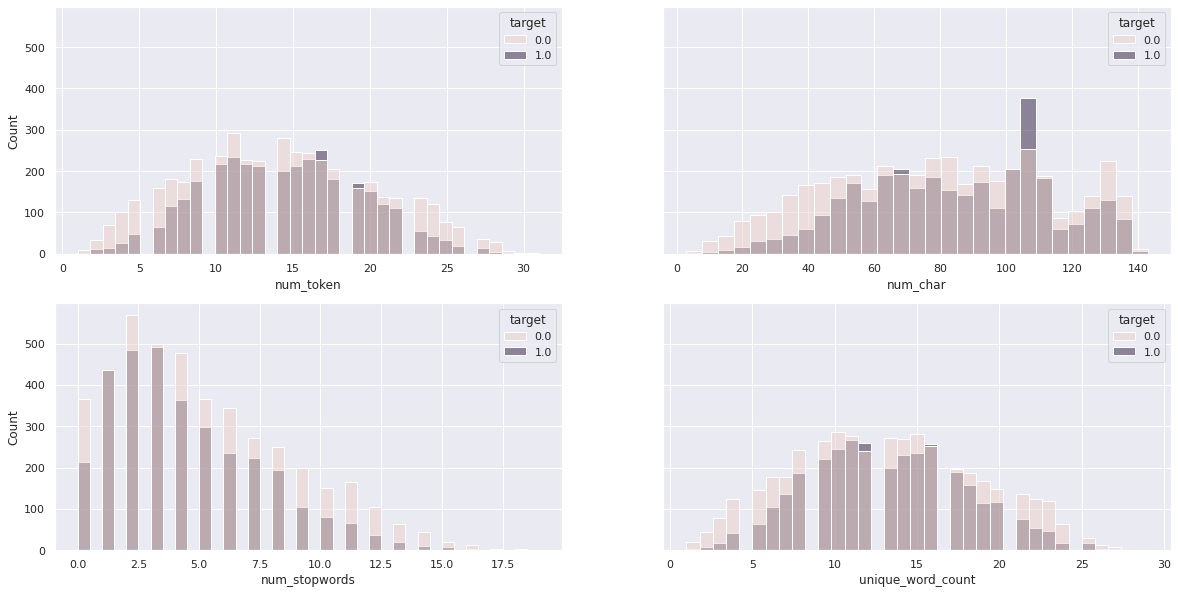

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharey=True)
sns.histplot(ax=axes[0, 0], data= all_data_cleaned.reset_index(), x="num_token", hue="target");
sns.histplot(ax = axes[0,1], data = all_data_cleaned.reset_index(), x="num_char", hue="target");
sns.histplot(ax = axes[1,0], data = all_data_cleaned.reset_index(), x="num_stopwords", hue="target");
sns.histplot(ax = axes[1,1], data = all_data_cleaned.reset_index(), x="unique_word_count", hue="target");

## 5. Inspect The data More

In [31]:
all_data_cleaned.head(3)

,id,keyword,text,target,text_cleaned,num_token,num_char,num_stopwords,unique_word_count
2644,3796,destruction,So you have a new weapon that can cause un-ima...,1.0,so you have a new weapon that can cause unimag...,11,64,6,11
2227,3185,deluge,The f$&amp;@ing things I do for #GISHWHES Just...,0.0,the famping things i do for gishwhes just got ...,21,109,9,19
5448,7769,police,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1.0,dt georgegalloway rt gallowaymayor the col pol...,15,92,4,14


In [33]:
words_in_a_sentences = [len(x) for x in all_data_cleaned["text_cleaned"].str.split(" ")]
all_words = [token for sentence in  all_data_cleaned["text_cleaned"].str.split(" ") for token in sentence]
vocabulary = sorted(list(set(all_words)))
print("vocabulary size: ",len(vocabulary))

vocabulary size:  22409


In [34]:
import collections
word_counts_df = pd.Series(collections.Counter(all_words)).to_frame('count').reset_index().rename(columns={'index': 'word'})
word_counts_df = word_counts_df.sort_values("count",ascending=False)
word_counts_df.head()

,word,count
29,,5480
11,the,4581
3,a,3085
42,to,2827
21,in,2789


In [ ]:
import numpy as np


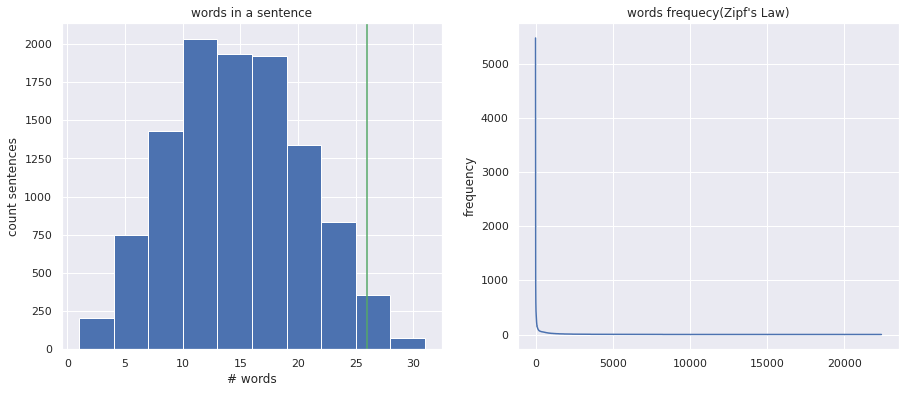

In [48]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.hist(words_in_a_sentences)
plt.axvline(x=np.percentile(words_in_a_sentences,98),c="g")
plt.title("words in a sentence")
plt.xlabel("# words")
plt.ylabel("count sentences")

plt.subplot(1,2,2)
plt.plot(word_counts_df['count'].values)
plt.title("words frequecy(Zipf's Law)")
plt.ylabel("frequency")
plt.show()

In [49]:
import numpy as np
np.percentile(words_in_a_sentences,98)

26.0

In [50]:
# what is the number of words which appear at least twise
word_counts_df_twice = word_counts_df[word_counts_df['count']>=2]
word_counts_df_twice.shape # number of words appear at least twice

(8231, 2)

note: as you can see from the graphs, plot 1 shows that majority sentences have words upt to 32, and plot2 shows the principle of zip's law which means that few words appear in the text very often and a lot of words appear in a corpus really few times

## 6. prepare data for training

In [55]:
#train test split
train_df.shape[0], test_df.shape[0]

(7613, 3263)

In [56]:
train_df_cleaned = all_data_cleaned.iloc[0:train_df.shape[0],:]
test_df_cleaned = all_data_cleaned.iloc[train_df.shape[0]:, :]

In [57]:
train, val, train_labels, val_labels = train_test_split(train_df_cleaned, # we can try text_cleaned also
                                                                                                              train_df_cleaned["target"].values,
                                                                                                              test_size=0.15,  
                                                                                                              random_state=42)
train.shape, val.shape, train_labels.shape, val_labels.shape

((6471, 9), (1142, 9), (6471,), (1142,))

In [58]:
# text data
train_sentences = train['text_cleaned'].values
val_sentences = val['text_cleaned'].values
test_sentences = test_df_cleaned['text_cleaned'].values
len(train_sentences), len(val_sentences), len(test_sentences)

(6471, 1142, 3263)

In [59]:
# numerical data
encoder= ce.BaseNEncoder(cols=['keyword'], return_df=True , base=2)
train_keyword_base_8 = encoder.fit_transform(train)
val_keyword_base_8 = encoder.transform(val)
test_keyword_base_8 = encoder.transform(test_df_cleaned)

train_keyword_base_8 = tf.constant(train_keyword_base_8[['keyword_0',	'keyword_1',	'keyword_2',	'keyword_3',	'keyword_4',	'keyword_5',	'keyword_6',	'keyword_7',	'keyword_8'	]])
val_keyword_base_8 = tf.constant(val_keyword_base_8[['keyword_0',	'keyword_1',	'keyword_2',	'keyword_3',	'keyword_4',	'keyword_5',	'keyword_6',	'keyword_7',	'keyword_8'	]])
test_keyword_base_8 = tf.constant(test_keyword_base_8[['keyword_0',	'keyword_1',	'keyword_2',	'keyword_3',	'keyword_4',	'keyword_5',	'keyword_6',	'keyword_7',	'keyword_8'	]])

train_keyword_base_8.shape, val_keyword_base_8.shape, test_keyword_base_8.shape

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


(TensorShape([6471, 9]), TensorShape([1142, 9]), TensorShape([3263, 9]))

In [60]:
scaler = MinMaxScaler()
train.loc[:, ['num_token','num_char','num_stopwords','unique_word_count']] = scaler.fit_transform(train.loc[:, ['num_token','num_char','num_stopwords','unique_word_count']])
val.loc[:, ['num_token','num_char','num_stopwords','unique_word_count']] = scaler.transform(val.loc[:, ['num_token','num_char','num_stopwords','unique_word_count']])
test_df_cleaned.loc[:, ['num_token','num_char','num_stopwords','unique_word_count']] = scaler.transform(test_df_cleaned.loc[:, ['num_token','num_char','num_stopwords','unique_word_count']])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [61]:
train_num_cols = tf.constant(train[['num_token','num_char','num_stopwords','unique_word_count']].values)
val_num_cols = tf.constant(val[['num_token','num_char','num_stopwords','unique_word_count']].values)
test_num_cols = tf.constant(test_df_cleaned[['num_token','num_char','num_stopwords','unique_word_count']].values)
train_num_cols.shape, val_num_cols.shape, test_num_cols.shape

(TensorShape([6471, 4]), TensorShape([1142, 4]), TensorShape([3263, 4]))

In [62]:
train_num_cols_final = tf.concat([ tf.cast(train_keyword_base_8,dtype=tf.float64),train_num_cols],axis=1 )
val_num_cols_final = tf.concat([tf.cast(val_keyword_base_8,dtype=tf.float64),val_num_cols],axis=1 )
test_num_cols_final = tf.concat([tf.cast(test_keyword_base_8,dtype=tf.float64),test_num_cols],axis=1 )

train_num_cols_final.shape, val_num_cols_final.shape, test_num_cols_final.shape

(TensorShape([6471, 13]), TensorShape([1142, 13]), TensorShape([3263, 13]))

## 7. Embedding
1. TF-IDF
2. Word2Vec
3. Universal Sentence Encoder

In [63]:
# 1. TF-IDF
from sklearn.feature_extraction.text import  TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
train_sentences_TFIDF = tfidf_vectorizer.fit_transform(train_sentences)
val_sentences_TFIDF = tfidf_vectorizer.transform(val_sentences)
print(train_sentences_TFIDF.shape) # number of sentences and # of unique words)

(6471, 15234)


In [64]:
# 2. Word2Vec
#from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings(action = 'ignore')
import tensorflow_hub as hub
embed_word_2_vec = hub.load("https://tfhub.dev/google/Wiki-words-500/2")
train_sentences_word_2_vec = embed_word_2_vec(train_sentences)
val_sentences_word_2_vec = embed_word_2_vec(val_sentences)
print(train_sentences_word_2_vec.shape)

(6471, 500)


In [65]:
#3. Universal Sentence Encoder
embed_USE = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")
train_sentences_USE = embed_USE(train_sentences)
val_sentences_USE = embed_USE(val_sentences)
print(train_sentences_USE.shape)

(6471, 512)


In [66]:
from sklearn.decomposition import  TruncatedSVD
import matplotlib.patches as mpatches
import matplotlib

def plot_embedding(embed_data, labels,title):
        # do TruncatedSVD
        svd = TruncatedSVD(n_components=2)
        svd_scores = svd.fit_transform(embed_data)
        colors = ['blue','red']
        plt.scatter(svd_scores[:,0], svd_scores[:,1], s=7, alpha=.6, c=labels, cmap=matplotlib.colors.ListedColormap(colors))
        red_patch = mpatches.Patch(color='blue', label='No_disaster')
        green_patch = mpatches.Patch(color='red', label='Disaster')
        plt.legend(handles=[red_patch, green_patch], prop={'size': 10})
        plt.title(title)

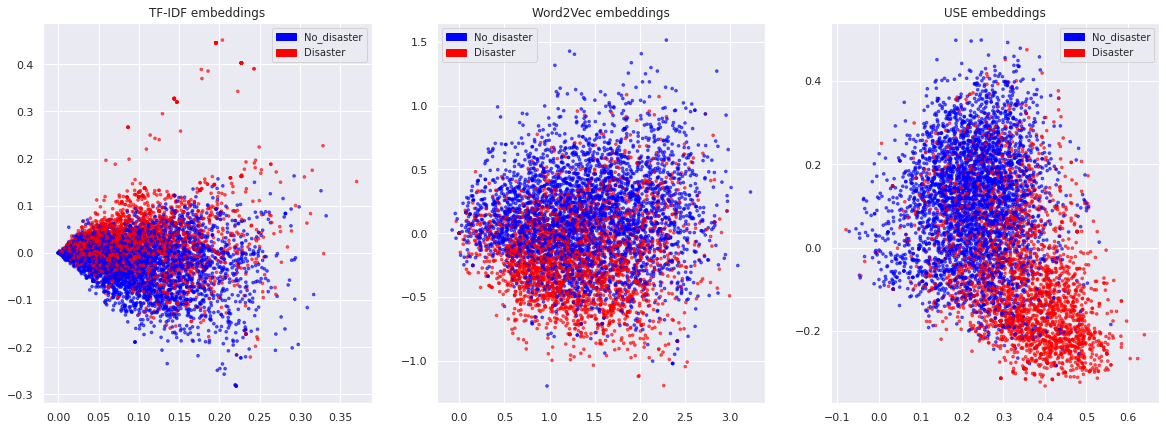

In [67]:
fig = plt.figure(figsize=(20, 7)) 
plt.subplot(1,3,1)         
plot_embedding(train_sentences_TFIDF, train_labels,"TF-IDF embeddings")

plt.subplot(1,3,2)         
plot_embedding(train_sentences_word_2_vec, train_labels,"Word2Vec embeddings")

plt.subplot(1,3,3)         
plot_embedding(train_sentences_USE, train_labels,"USE embeddings")


## 8. Training

In [139]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                  patience=3)
reduce_lr =  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2)

### 1. Model_0: Numerical Columns

In [69]:
input_num = layers.Input(shape=(13,),dtype=tf.float64)
x = layers.Dense(416,activation="relu")(input_num)
output_num = layers.Dense(1,activation="sigmoid")(x)
model_0 = tf.keras.Model(input_num,output_num) 

model_0.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="binary_crossentropy",
                metrics=['accuracy'])

model_0 = model_0.fit(train_num_cols_final,train_labels,
            epochs=20,
            validation_data = (val_num_cols_final,val_labels),
            callbacks =[early_stopping,reduce_lr])

Epoch 1/20
203/203 [==============================] - 1s 3ms/step - loss: 0.6670 - accuracy: 0.5962 - val_loss: 0.6579 - val_accuracy: 0.6086
Epoch 2/20
203/203 [==============================] - 0s 2ms/step - loss: 0.6486 - accuracy: 0.6266 - val_loss: 0.6491 - val_accuracy: 0.6191
Epoch 3/20
203/203 [==============================] - 0s 2ms/step - loss: 0.6336 - accuracy: 0.6472 - val_loss: 0.6450 - val_accuracy: 0.6270
Epoch 4/20
203/203 [==============================] - 0s 2ms/step - loss: 0.6266 - accuracy: 0.6480 - val_loss: 0.6292 - val_accuracy: 0.6602
Epoch 5/20
203/203 [==============================] - 0s 2ms/step - loss: 0.6155 - accuracy: 0.6608 - val_loss: 0.6189 - val_accuracy: 0.6690
Epoch 6/20
203/203 [==============================] - 0s 2ms/step - loss: 0.6084 - accuracy: 0.6735 - val_loss: 0.6165 - val_accuracy: 0.6673
Epoch 7/20
203/203 [==============================] - 0s 2ms/step - loss: 0.6030 - accuracy: 0.6773 - val_loss: 0.6075 - val_accuracy: 0.6778
Epoch 

### 2. Model_1: Textual Data + custom embedding

In [71]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
vocal_size = 10000
token_num_insentecne = 32
text_vectorization = TextVectorization(max_tokens=vocal_size, 
                                       output_sequence_length = token_num_insentecne
                  )
text_vectorization.adapt(train_sentences)

In [72]:
vocabulary = text_vectorization.get_vocabulary()
len(vocabulary)

10000

In [73]:
from tensorflow.keras.layers import Embedding
embedding_layer = Embedding(input_dim=len(vocabulary),
                      output_dim = 128,
                      mask_zero=True,
                      name = "embedding_layer"
                      )

In [82]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
test_vectors =text_vectorization(inputs)
token_embeddings = embedding_layer(test_vectors)
x = layers.Conv1D(filters=32,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x)
# x = layers.Bidirectional(layers.LSTM(32))(token_embeddings)
#x = layers.BatchNormalization()(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs,outputs)

model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="binary_crossentropy",
                metrics=['accuracy'])

history_1 = model_1.fit(train_sentences,train_labels,
                        batch_size=32,
                        epochs=20,
                        validation_data = (val_sentences,val_labels),
                        callbacks =[early_stopping,reduce_lr])

Epoch 1/20
203/203 [==============================] - 2s 5ms/step - loss: 0.1890 - accuracy: 0.9498 - val_loss: 0.7427 - val_accuracy: 0.7741
Epoch 2/20
203/203 [==============================] - 1s 4ms/step - loss: 0.0849 - accuracy: 0.9696 - val_loss: 0.8993 - val_accuracy: 0.7601
Epoch 3/20
203/203 [==============================] - 1s 4ms/step - loss: 0.0754 - accuracy: 0.9723 - val_loss: 0.9887 - val_accuracy: 0.7609
Epoch 4/20
203/203 [==============================] - 1s 4ms/step - loss: 0.0607 - accuracy: 0.9776 - val_loss: 1.0111 - val_accuracy: 0.7723


### 3. Model2: character Embeddings

In [83]:
# make funtion to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [84]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[0:3]

['c a r t o o n   b e a r s   w i t h o u t   t h e m   w e   w o u l d   q a v e   n o   k n o w l d d g e   o f   f o r e s t   f i r e s   o r   t o i l e t   p a p e r',
 'm i c h a e l   t a l k i n g   a b o u t   w h e n   h e   w a s   e l e c t r o c u t e d   o m g   r o w y s o l o u i s v i l l e  ',
 'l u n a s a g a l l e   s y n a p s e n k o t z e   \n t h e   e x p l o d e d   b e a n   t h e   b a s t a r d']

In [85]:
# what is average character length
import numpy as np
char_lens = [len(sent)  for sent in train_sentences]
print(round(np.mean(char_lens))) # mean characters
print(round(np.std(char_lens)))

82
31


In [86]:
char_length = int(np.percentile(char_lens,95))
char_length

132

In [87]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [88]:
# create a char- leel tokenizer
num_CHAR_TOKENS = len(alphabet) +2  # for empty space and for UNK
char_vectorizer = TextVectorization(max_tokens=num_CHAR_TOKENS,
                                    output_sequence_length = char_length,
                                    standardize=None # if i want to leave punctuation
                                    )
char_vectorizer.adapt(train_chars)

In [94]:
# check character vocal stats
char_vocab  = char_vectorizer.get_vocabulary()
print(char_vocab)
print(len(char_vocab))

['', '[UNK]', 'e', 'a', 't', 'i', 'o', 'n', 's', 'r', 'l', 'h', 'd', 'c', 'u', 'm', 'g', 'f', 'p', 'y', 'w', 'b', 'k', 'v', 'j', 'x', 'z', '!', 'q', '|', '~', '}', '{', '`']
34


In [95]:
char_embedding = tf.keras.layers.Embedding(
    input_dim = len(char_vocab),
    output_dim = 24,
    mask_zero = True,
    name="char_embedidng"
)

In [98]:
inputs = layers.Input(shape=(1,), dtype="string")
char_vectorizer_2 = char_vectorizer(inputs)
char_embed = char_embedding(char_vectorizer_2)
#x = layers.Bidirectional(layers.LSTM(32))(char_embed)
x = layers.Conv1D(filters=32,kernel_size=5,padding="same",activation="relu")(char_embed)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1,activation="sigmoid",name="output_layer")(x)
model_2 = tf.keras.Model(inputs,outputs)

model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="binary_crossentropy",
                metrics=['accuracy'])

history_2 = model_2.fit(np.array(train_chars),train_labels,
            epochs=30,
            validation_data = (np.array(val_chars),val_labels),
            callbacks =[early_stopping,reduce_lr])

Epoch 1/30
203/203 [==============================] - 2s 5ms/step - loss: 0.6514 - accuracy: 0.6279 - val_loss: 0.6214 - val_accuracy: 0.6856
Epoch 2/30
203/203 [==============================] - 1s 5ms/step - loss: 0.5862 - accuracy: 0.7147 - val_loss: 0.5786 - val_accuracy: 0.7110
Epoch 3/30
203/203 [==============================] - 1s 4ms/step - loss: 0.5464 - accuracy: 0.7388 - val_loss: 0.5549 - val_accuracy: 0.7285
Epoch 4/30
203/203 [==============================] - 1s 4ms/step - loss: 0.5141 - accuracy: 0.7565 - val_loss: 0.5411 - val_accuracy: 0.7391
Epoch 5/30
203/203 [==============================] - 1s 5ms/step - loss: 0.4903 - accuracy: 0.7772 - val_loss: 0.5371 - val_accuracy: 0.7504
Epoch 6/30
203/203 [==============================] - 1s 4ms/step - loss: 0.4711 - accuracy: 0.7895 - val_loss: 0.5285 - val_accuracy: 0.7417
Epoch 7/30
203/203 [==============================] - 1s 4ms/step - loss: 0.4556 - accuracy: 0.7937 - val_loss: 0.5264 - val_accuracy: 0.7636
Epoch 

### 4. Model_3: train with USE

In [99]:
import tensorflow_hub as hub
USE_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",trainable=False,name="universal_sentence_encoder")

In [104]:
inputs = layers.Input(shape=[], dtype=tf.string)
use_layer = USE_layer(inputs)
x = layers.Dense(128,activation="relu")(use_layer)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs,outputs)
model_3.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="binary_crossentropy",
                metrics=['accuracy'])
history_3 = model_3.fit(train_sentences,train_labels,
                        batch_size=32,
                      epochs=30,
                      validation_data = (val_sentences,val_labels),
                      callbacks =[early_stopping,reduce_lr])

Epoch 1/30
203/203 [==============================] - 3s 12ms/step - loss: 0.4891 - accuracy: 0.7829 - val_loss: 0.4607 - val_accuracy: 0.7898
Epoch 2/30
203/203 [==============================] - 2s 10ms/step - loss: 0.4043 - accuracy: 0.8198 - val_loss: 0.4510 - val_accuracy: 0.8021
Epoch 3/30
203/203 [==============================] - 2s 10ms/step - loss: 0.3890 - accuracy: 0.8266 - val_loss: 0.4471 - val_accuracy: 0.8074
Epoch 4/30
203/203 [==============================] - 2s 10ms/step - loss: 0.3804 - accuracy: 0.8328 - val_loss: 0.4414 - val_accuracy: 0.8152
Epoch 5/30
203/203 [==============================] - 2s 10ms/step - loss: 0.3703 - accuracy: 0.8374 - val_loss: 0.4433 - val_accuracy: 0.8082
Epoch 6/30
203/203 [==============================] - 2s 10ms/step - loss: 0.3613 - accuracy: 0.8422 - val_loss: 0.4430 - val_accuracy: 0.8074
Epoch 7/30
203/203 [==============================] - 2s 10ms/step - loss: 0.3424 - accuracy: 0.8530 - val_loss: 0.4431 - val_accuracy: 0.8117

### 5. Model_4: BERT

In [114]:
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/2" # @param {type: "string"} ["https://tfhub.dev/google/experts/bert/wiki_books/2", "https://tfhub.dev/google/experts/bert/wiki_books/mnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qqp/2", "https://tfhub.dev/google/experts/bert/wiki_books/squad2/2", "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2",  "https://tfhub.dev/google/experts/bert/pubmed/2", "https://tfhub.dev/google/experts/bert/pubmed/squad2/2"]
# Preprocessing must match the model, but all the above use the same.
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
preprocessing_layer = hub.KerasLayer(PREPROCESS_MODEL, name='preprocessing')
bert_encoder_layer = hub.KerasLayer(BERT_MODEL, trainable=False,name="BERT_encoder")

In [129]:
bert_inputs = layers.Input(shape=(), dtype=tf.string, name="text")
x = preprocessing_layer(bert_inputs)
x = bert_encoder_layer(x)
net = x['pooled_output']
net = tf.keras.layers.Dropout(0.1)(net)
x = layers.Dense(128, activation="relu")(net)
bert_outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(bert_inputs,bert_outputs )

In [130]:
model_4.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="binary_crossentropy",
                metrics=['accuracy'])

history_4 = model_4.fit(train_sentences,train_labels,
                        batch_size=32,
            epochs=30,
            validation_data = (val_sentences,val_labels),
            callbacks =[early_stopping,reduce_lr])

Epoch 1/30
203/203 [==============================] - 51s 242ms/step - loss: 0.5962 - accuracy: 0.6830 - val_loss: 0.5811 - val_accuracy: 0.7119
Epoch 2/30
203/203 [==============================] - 48s 239ms/step - loss: 0.5328 - accuracy: 0.7442 - val_loss: 0.5145 - val_accuracy: 0.7574
Epoch 3/30
203/203 [==============================] - 48s 238ms/step - loss: 0.5169 - accuracy: 0.7555 - val_loss: 0.5006 - val_accuracy: 0.7653
Epoch 4/30
203/203 [==============================] - 48s 238ms/step - loss: 0.5062 - accuracy: 0.7589 - val_loss: 0.5333 - val_accuracy: 0.7566
Epoch 5/30
203/203 [==============================] - 48s 238ms/step - loss: 0.4959 - accuracy: 0.7662 - val_loss: 0.5181 - val_accuracy: 0.7548
Epoch 6/30
203/203 [==============================] - 48s 238ms/step - loss: 0.4630 - accuracy: 0.7861 - val_loss: 0.5012 - val_accuracy: 0.7653


### 6. Model_5: Combination of token_level model, char_leevl_model and numerical_level_model

In [131]:
# prepare the data
train_dataset_model = tf.data.Dataset.from_tensor_slices(( train_num_cols_final, train_sentences,  train_chars ))
train_dataset_model_label = tf.data.Dataset.from_tensor_slices(train_labels)
train_dataset_model = tf.data.Dataset.zip((train_dataset_model,train_dataset_model_label))
train_dataset_model = train_dataset_model.batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset_model = tf.data.Dataset.from_tensor_slices(( val_num_cols_final, val_sentences,  val_chars ))
val_dataset_model_label = tf.data.Dataset.from_tensor_slices(val_labels)
val_dataset_model = tf.data.Dataset.zip((val_dataset_model,val_dataset_model_label))
val_dataset_model = val_dataset_model.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset_model = tf.data.Dataset.from_tensor_slices(( test_num_cols_final, test_sentences,  test_chars ))
test_dataset_model = test_dataset_model.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset_model, val_dataset_model, test_dataset_model

(<PrefetchDataset shapes: (((None, 13), (None,), (None,)), (None,)), types: ((tf.float64, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 13), (None,), (None,)), (None,)), types: ((tf.float64, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: ((None, 13), (None,), (None,)), types: (tf.float64, tf.string, tf.string)>)

In [135]:
#1. Token inputs
token_inputs = layers.Input(shape=[],dtype="string",name="token_inputs")
token_embeddings = USE_layer(token_inputs)
token_outputs = layers.Dense(128,activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs,token_outputs )

#2 . char inputs
char_inputs = layers.Input(shape=(1,),dtype=tf.string,name = "char_input")
char_vector = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vector)
x = layers.Conv1D(filters=32,kernel_size=5,padding="same",activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
#x = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(char_inputs, x)

#3. line_number feature
input_num = layers.Input(shape=(13,),dtype=tf.float64)
x = layers.Dense(416,activation="relu")(input_num)
output_num = layers.Dense(1,activation="sigmoid")(x)
num_model = tf.keras.Model(input_num,output_num) 

#4. Concatinate
combined_embeddigns = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                                                                                            char_model.output ])

z = layers.Dropout(0.1)(combined_embeddigns)
#z = layers.BatchNormalization()(combined_embeddigns)
tribrid_embeedding = layers.Concatenate(name="char_token_positional_embedding")([num_model.output,
                                                                                                                                          z])
output_layer = layers.Dense(1,activation="sigmoid",name = "output_layer")(tribrid_embeedding)

# 5 model
model_combined = tf.keras.Model(inputs=[num_model.input,
                                                                      token_model.input,
                                                                      char_model.input],
                                                        outputs = [output_layer])

In [133]:
model_combined.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="binary_crossentropy",
                metrics=['accuracy'])

In [134]:
history_final = model_combined.fit(train_dataset_model,
            epochs=30,
            validation_data = val_dataset_model,
            callbacks =[early_stopping,reduce_lr])

Epoch 1/30
203/203 [==============================] - 4s 14ms/step - loss: 0.4865 - accuracy: 0.7803 - val_loss: 0.4534 - val_accuracy: 0.7951
Epoch 2/30
203/203 [==============================] - 2s 12ms/step - loss: 0.4025 - accuracy: 0.8214 - val_loss: 0.4488 - val_accuracy: 0.8039
Epoch 3/30
203/203 [==============================] - 2s 12ms/step - loss: 0.3869 - accuracy: 0.8260 - val_loss: 0.4446 - val_accuracy: 0.8117
Epoch 4/30
203/203 [==============================] - 2s 12ms/step - loss: 0.3744 - accuracy: 0.8331 - val_loss: 0.4428 - val_accuracy: 0.8196
Epoch 5/30
203/203 [==============================] - 2s 12ms/step - loss: 0.3623 - accuracy: 0.8387 - val_loss: 0.4399 - val_accuracy: 0.8161
Epoch 6/30
203/203 [==============================] - 2s 12ms/step - loss: 0.3492 - accuracy: 0.8481 - val_loss: 0.4403 - val_accuracy: 0.8126
Epoch 7/30
203/203 [==============================] - 2s 12ms/step - loss: 0.3391 - accuracy: 0.8523 - val_loss: 0.4388 - val_accuracy: 0.8109

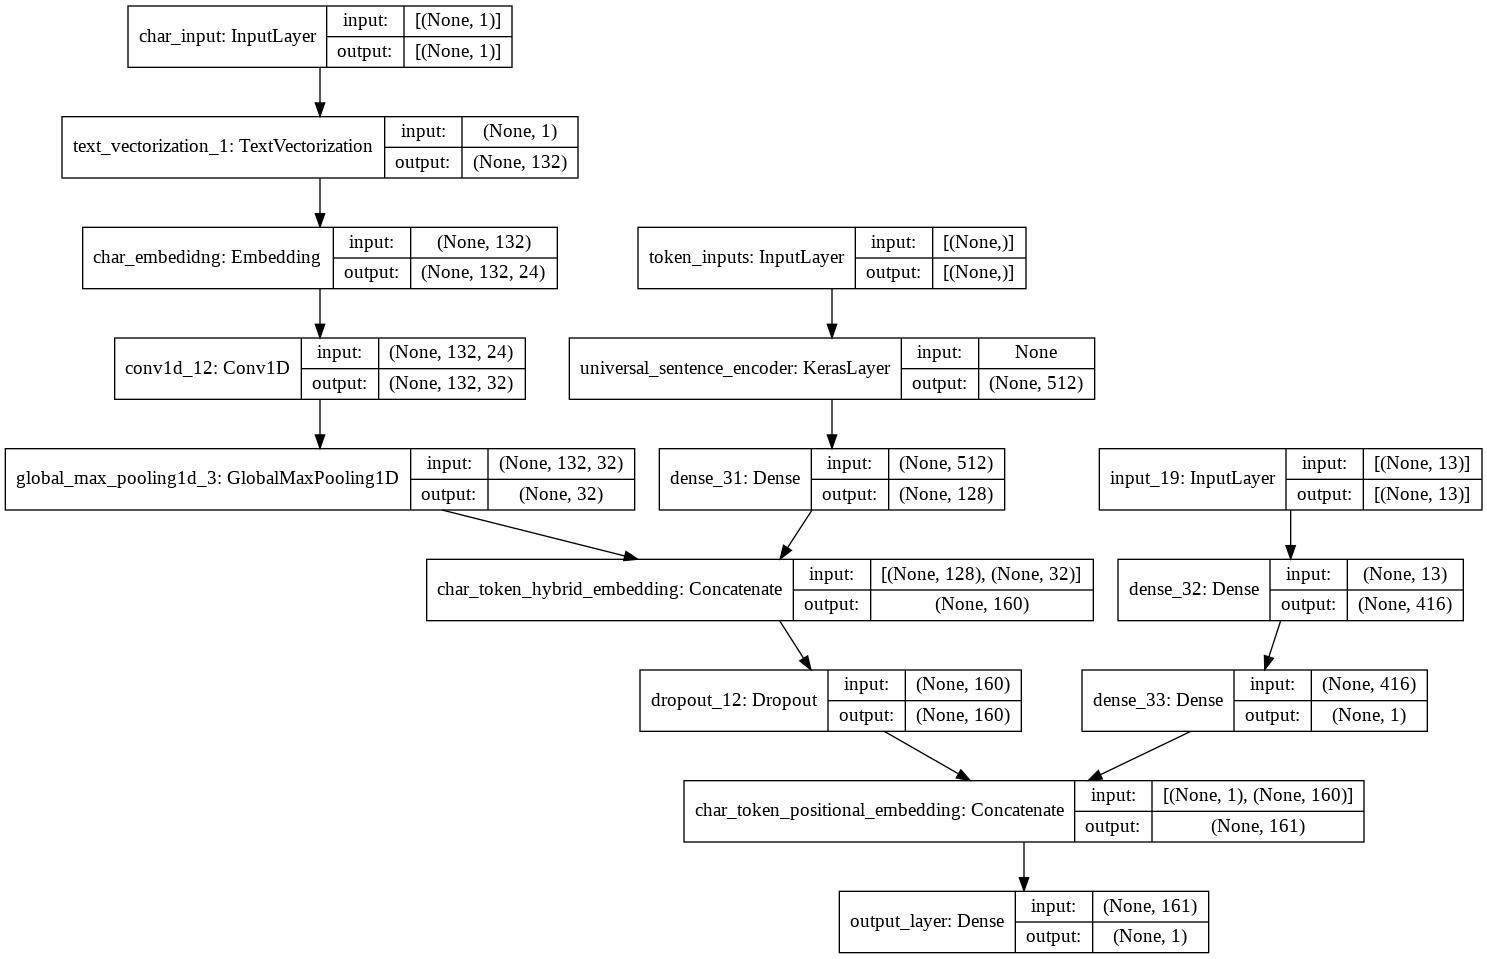

In [136]:
from tensorflow.keras.utils import plot_model
plot_model(model_combined,show_shapes=True)

## HyperParam Tuning

In [140]:
def model_builder_USE(hp):
  inputs = layers.Input(shape=[], dtype=tf.string)
  use_layer = USE_layer(inputs)
  hp_units = hp.Int('units', min_value=64, max_value=448, step=64)
  x = layers.Dense(units=hp_units, activation="relu")(use_layer)
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = tf.keras.Model(inputs,outputs)
  
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="binary_crossentropy",
                  metrics=['accuracy'])
  return model

In [141]:
tuner = kt.Hyperband(model_builder_USE,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='dir',
                     project_name='USE')

history = tuner.search(train_sentences,train_labels,
                       batch_size=32,
            epochs=30,
            validation_data = (val_sentences,val_labels),
            callbacks =[early_stopping])

Trial 7 Complete [00h 00m 15s]
val_accuracy: 0.8003502488136292

Best val_accuracy So Far: 0.8064798712730408
Total elapsed time: 00h 02m 53s


In [142]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.get('units'))

384


In [143]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_sentences,train_labels,
                    batch_size=32,
            epochs=30,
            validation_data = (val_sentences,val_labels))

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/30
203/203 [==============================] - 3s 12ms/step - loss: 0.4702 - accuracy: 0.7980 - val_loss: 0.4584 - val_accuracy: 0.7986
Epoch 2/30
203/203 [==============================] - 2s 10ms/step - loss: 0.3965 - accuracy: 0.8252 - val_loss: 0.4543 - val_accuracy: 0.8021
Epoch 3/30
203/203 [==============================] - 2s 10ms/step - loss: 0.3787 - accuracy: 0.8343 - val_loss: 0.4419 - val_accuracy: 0.8161
Epoch 4/30
203/203 [==============================] - 2s 10ms/step - loss: 0.3618 - accuracy: 0.8416 - val_loss: 0.4445 - val_accuracy: 0.8100
Epoch 5/30
203/203 [==============================] - 2s 10ms/step - loss: 0.3421 - accuracy: 0.8504 - val_loss: 0.4456 - val_accuracy: 0.8100
Epoch 6/30
203/203 [==============================] - 2s 10ms/step - loss: 0.3220 - accuracy: 0.8614 - val_loss: 0.4452 - val_accuracy: 0.8091
Epoch 7/30
203/203 [==============================] - 2s 10ms/step - loss: 0.2996 - accuracy: 0.8739 - val_loss: 0.4429 - val_accuracy: 0.8126

## Full

In [144]:
full_data = np.concatenate((train_sentences,val_sentences))
full_data_labels = np.concatenate((train_labels,val_labels))
len(full_data), len(full_data_labels)

(7613, 7613)

In [149]:
model = tuner.hypermodel.build(best_hps)
model.fit(full_data,full_data_labels,
            epochs=best_epoch ,
          batch_size=32)

Epoch 1/9
238/238 [==============================] - 3s 9ms/step - loss: 0.4618 - accuracy: 0.7968
Epoch 2/9
238/238 [==============================] - 2s 9ms/step - loss: 0.4010 - accuracy: 0.8227
Epoch 3/9
238/238 [==============================] - 2s 9ms/step - loss: 0.3822 - accuracy: 0.8354
Epoch 4/9
238/238 [==============================] - 2s 9ms/step - loss: 0.3630 - accuracy: 0.8403
Epoch 5/9
238/238 [==============================] - 2s 9ms/step - loss: 0.3423 - accuracy: 0.8512
Epoch 6/9
238/238 [==============================] - 2s 9ms/step - loss: 0.3202 - accuracy: 0.8629
Epoch 7/9
238/238 [==============================] - 2s 9ms/step - loss: 0.2955 - accuracy: 0.8764
Epoch 8/9
238/238 [==============================] - 2s 9ms/step - loss: 0.2722 - accuracy: 0.8906
Epoch 9/9
238/238 [==============================] - 2s 9ms/step - loss: 0.2465 - accuracy: 0.9033


In [150]:
model_pred_probs = model.predict(test_sentences)
model_pred_probs

array([[0.46877754],
       [0.9826095 ],
       [0.7987206 ],
       ...,
       [0.9846295 ],
       [0.8844952 ],
       [0.67815614]], dtype=float32)

In [151]:
model_pred =tf.cast(tf.squeeze(tf.round(model_pred_probs),axis=1),dtype=tf.int16)
model_pred

<tf.Tensor: shape=(3263,), dtype=int16, numpy=array([0, 1, 1, ..., 1, 1, 1], dtype=int16)>

In [152]:
sabmision = pd.read_csv("/content/sample_submission.csv")
sabmision['target'] = model_pred
sabmision.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [168]:
sabmision.to_csv("submision_final.csv",index=False)